#### Code to extract data

**TODO** : 
- lung localizer to crop + window

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/kaggle/siim_covid/src


## Imports

In [3]:
import os
import cv2
import glob
import gdcm
import pydicom
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.notebook import tqdm

In [4]:
from params import *
from data.extraction import *

In [5]:
# VFLIP : train/77539184cdaf/70852a51cfe9/24d0b38302d5.dcm

In [6]:
paths = glob.glob(TRAIN_DCM_PATH + "*/*/*.dcm")

path = TRAIN_DCM_PATH + "c29970048923/fc3ba5dcfffe/7b3e9f13d4e7.dcm"
path = TRAIN_DCM_PATH + "c29970048923/b67d36eb6f80/76c66ee8e58d.dcm"

path = TRAIN_DCM_PATH + "7dfd6afee3e9/9d4cc02b1e1d/1419506711be.dcm"

path = TRAIN_DCM_PATH + "49374ea79cdd/5fc4fbdcff53/b5a415f70aa9.dcm"
path = TRAIN_DCM_PATH + "b30c87707a75/6168aac73628/84135cf828e7.dcm"

path = TRAIN_DCM_PATH + "970c96c9fa5d/6520d1e28fc1/c636ac67c19a.dcm"
# path = TRAIN_DCM_PATH + "970c96c9fa5d/c539c837a4b7/e738c549fe8e.dcm"

# path = TRAIN_DCM_PATH + "230f160d4a7c/5981ea31f680/538525f017ca.dcm"
# path = TRAIN_DCM_PATH + "3f2ca41bae34/280e30eab869/1679d20fa0bc.dcm"
# path = TRAIN_DCM_PATH + "1c939db63c15/d412342fe6fa/282846988f20.dcm"

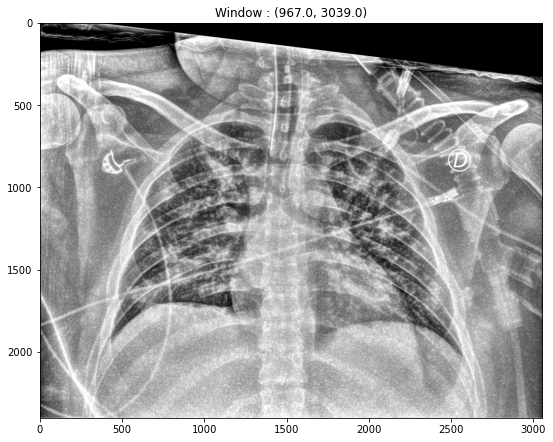

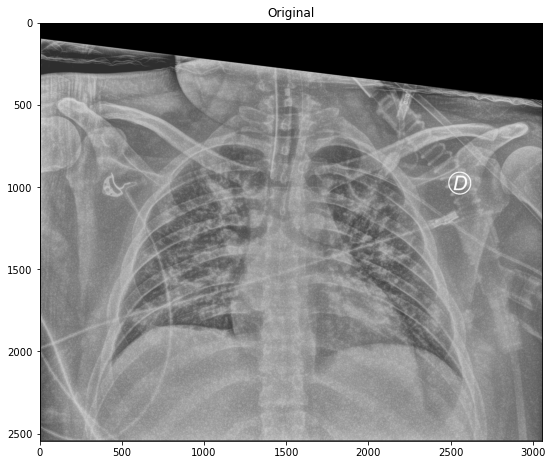

In [7]:
img, metadata = read_xray(path)

# sns.histplot(img.flatten())
# plt.axvline(end, c="salmon")
# plt.axvline(start, c="salmon")
# plt.show()

img_w, window = auto_windowing(img)
img_, starts = remove_padding(img_w)

plt.figure(figsize=(9, 9))
plt.imshow(img_, cmap="gray")
plt.title(f'Window : {window}')
plt.show()

plt.figure(figsize=(9, 9))
plt.imshow(img, cmap="gray")
plt.title(f'Original')
plt.show()

Image ../../../data/siim_covid/train/93e8a7d28f91/756cd83f1b1f/ce2f74669711.dcm


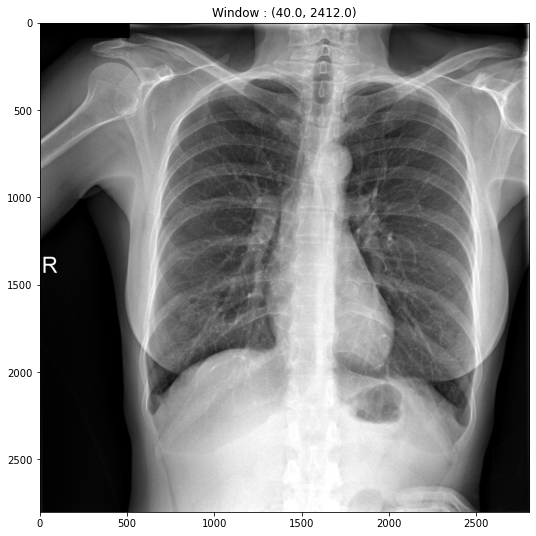

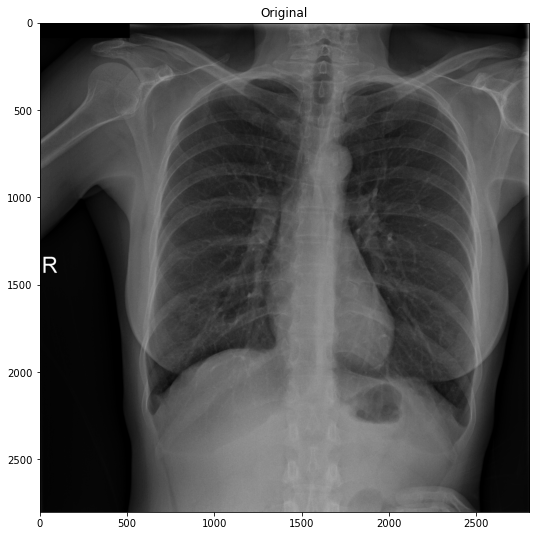

In [8]:
for path in np.random.choice(paths, 1):
    print(f"Image {path}")
    img, metadata = read_xray(path)

    # sns.histplot(img.flatten())
    # plt.axvline(end, c="salmon")
    # plt.axvline(start, c="salmon")
    # plt.show()

    img_, window = auto_windowing(img.copy())
    img_, starts = remove_padding(img_)

    plt.figure(figsize=(9, 9))
    plt.imshow(img_, cmap="gray")
    plt.title(f'Window : {window}')
    plt.show()

    plt.figure(figsize=(9, 9))
    plt.imshow(img, cmap="gray")
    plt.title(f'Original')
    plt.show()
    
#     break

### Params

In [9]:
if not os.path.exists(DCM_PATH):
    DCM_PATH = DATA_PATH

In [10]:
SIZE = 512
DATABASE = "train"
SAVE_DIR = DATA_PATH + f"{DATABASE}_{SIZE}/"

if not os.path.exists(SAVE_DIR):
    os.mkdir(SAVE_DIR)

In [11]:
df = pd.read_csv(DATA_PATH + "train_image_level.csv")

  0%|          | 0/6334 [00:00<?, ?it/s]

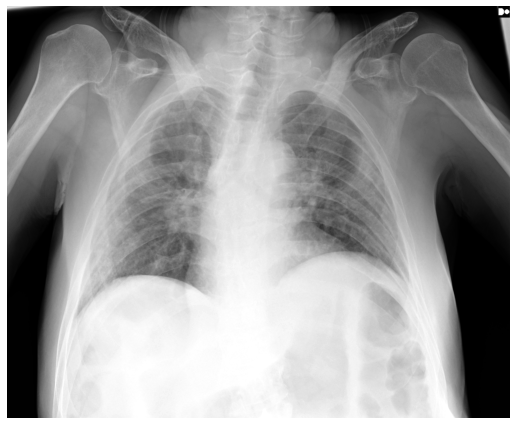

/home/theo/venv/lib/python3.8/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:341: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


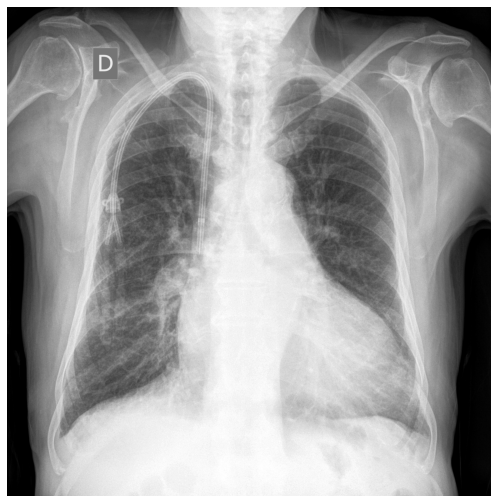

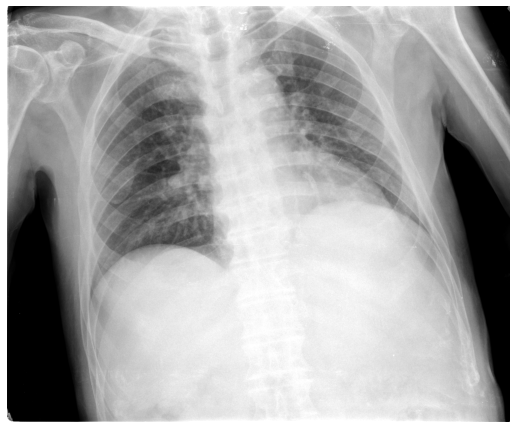

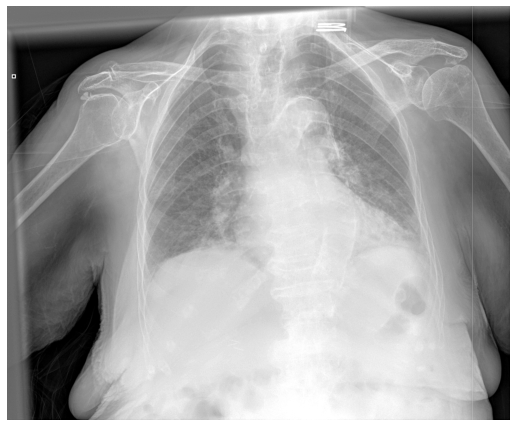

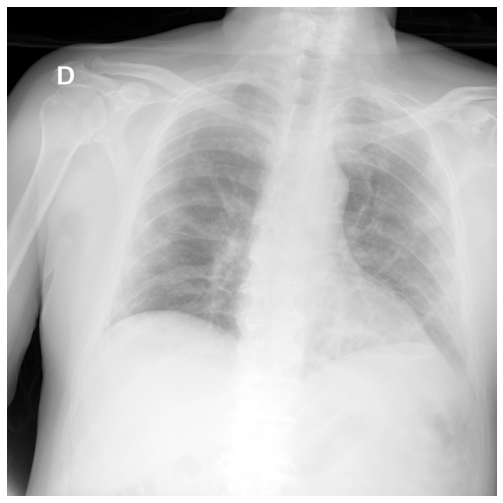

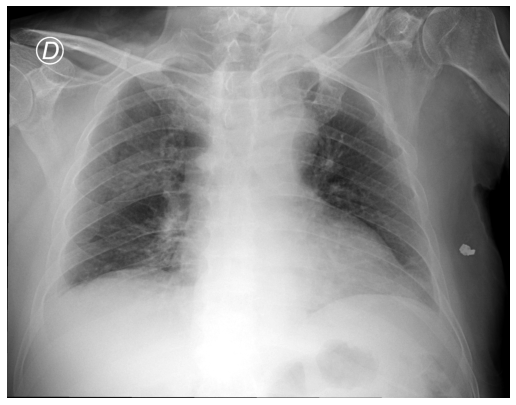

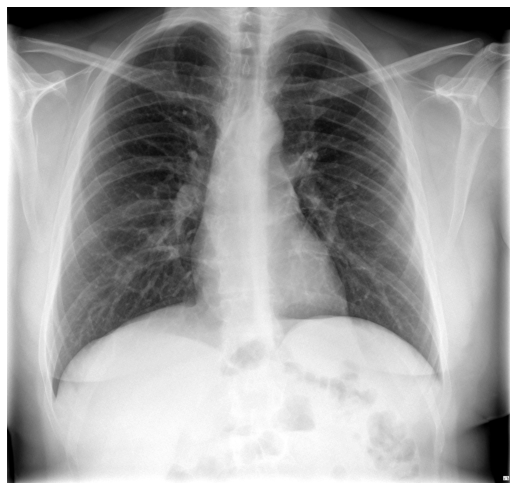

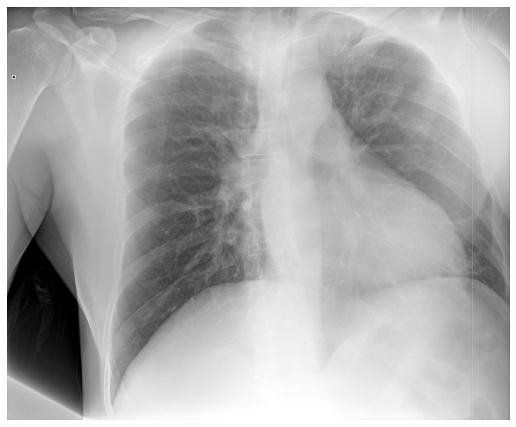

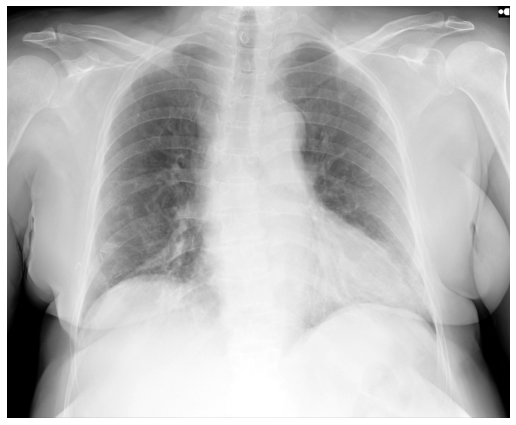

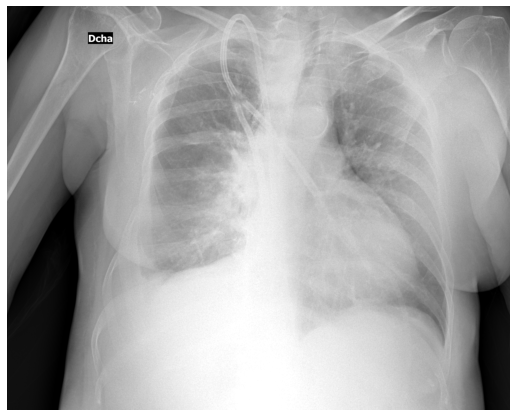

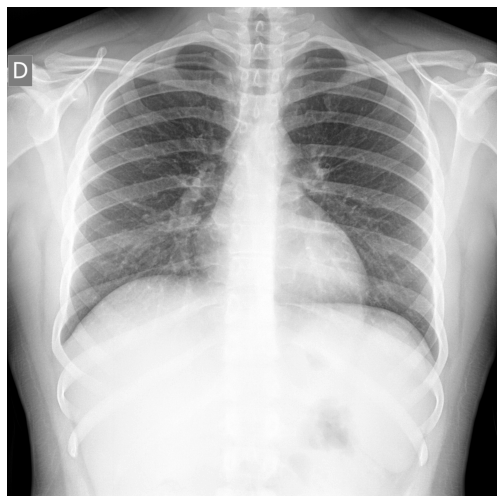

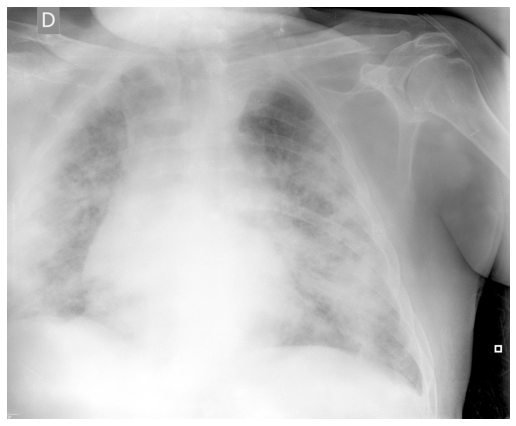

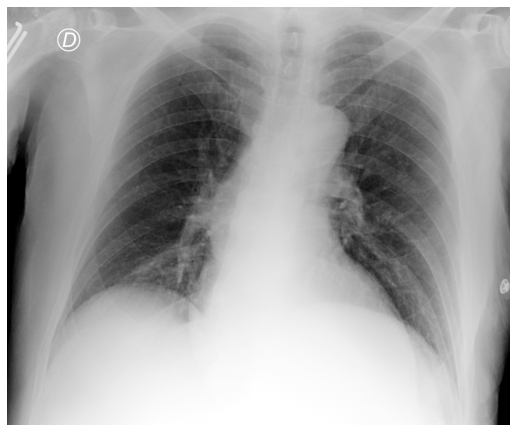

In [12]:
infos = []
for i in tqdm(range(len(df))):
    study = df['StudyInstanceUID'][i]
    image = df['id'][i].split('_')[0]

    study_path = os.path.join(DCM_PATH, DATABASE, study)
    series = os.listdir(study_path)
    
    found = False
    for s in series:
        img_path = os.path.join(study_path, s, image + ".dcm")
        if os.path.exists(img_path):
            found = True
            break
            
    if not found:
        print(f'Image {i} not found')
        continue
    
    img, meta = read_xray(img_path)
    shape = img.shape

    img, window = auto_windowing(img)

    img, crop_starts = remove_padding(img)
    
    shape_crop = img.shape

    if not (i % 500):
        plt.figure(figsize=(9, 9))
        plt.imshow(img, cmap="gray")
        plt.axis(False)
        plt.show()
        
    img = cv2.resize(img, (SIZE, SIZE), interpolation=cv2.INTER_LINEAR)
    
    save_name = f"{study}_{image}.png"
    cv2.imwrite(SAVE_DIR + save_name, img)

    info_dic = {
        "study_id": [study],
        "series_id": [s],
        "image_id": [image],
        "save_name": [save_name],
        "shape": [shape],
        "shape_crop": [shape_crop],
        "window": [window],
        "crop_starts": [crop_starts],
        "photometric_interpreation": [meta.PhotometricInterpretation],
        "series_number": [meta.SeriesNumber],
        "instance_number": [meta.InstanceNumber],
    }
    infos.append(pd.DataFrame.from_dict(info_dic))

#     break

infos = pd.concat(infos).reset_index(drop=True)

if len(infos) == len(df):
    infos.to_csv(DATA_PATH + f'df_{DATABASE}_{SIZE}.csv', index=False)

In [13]:
infos.head()

,study_id,series_id,image_id,save_name,shape,shape_crop,window,crop_starts,photometric_interpreation,series_number,instance_number
0,5776db0cec75,81456c9c5423,000a312787f2,5776db0cec75_000a312787f2.png,"(3488, 4256)","(3487, 4255)","(26.0, 3495.0)","(0, 0)",MONOCHROME2,1,1
1,ff0879eb20ed,d8a644cc4f93,000c3a3f293f,ff0879eb20ed_000c3a3f293f.png,"(2320, 2832)","(2320, 2832)","(63.0, 241.0)","(0, 0)",MONOCHROME2,1,1
2,9d514ce429a7,22897cd1daa0,0012ff7358bc,9d514ce429a7_0012ff7358bc.png,"(2544, 3056)","(2540, 3052)","(18.0, 3154.0)","(4, 0)",MONOCHROME2,1,1
3,28dddc8559b2,4d47bc042ee6,001398f4ff4f,28dddc8559b2_001398f4ff4f.png,"(3520, 4280)","(3503, 4280)","(41.0, 4038.0)","(0, 0)",MONOCHROME1,1002,1002
4,dfd9fdd85a3e,49170afa4f27,001bd15d1891,dfd9fdd85a3e_001bd15d1891.png,"(2800, 3408)","(2800, 3408)","(1363.0, 14900.0)","(0, 0)",MONOCHROME1,1,1
